# Plot eclipse disk coverage

This notebook was created to plot an approximation of what the solar disk looks like during an eclipse at a particular location. This is largely based on the ipynb posted here: https://cocalc.com/share/public_paths/bf823e12dd03bf876f4a18b23f429972768733a7

In order to make this calculation, we need an ephemeris to plot the location of the moon relative to the sun. We want the plotting to be on a solar-centric grid. Therefore, we'll find the location of the sun, then find the azimuth and elevation of the moon relative to the sun and plot a black disk over that position.

## Preparation

Here's where we load all of the appropriate packages:

In [1]:
from datetime import datetime
import numpy as np
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as units

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib

from IPython.display import HTML

#  Define a site index to change between different locations

siteIdx = 1

## Locations

Let's geolocate our sites by creating a class of locations.

In [2]:
class sites:
    
    id=['sgp','rid']
    long_name=['ARM SGP','Richmond, IN']
    lat = [36.605211,39.816966]
    lon = [-97.485703,-84.912830]
    alt = [318,330]

## Processing

Here we're going to use the astropy toolbox to process the position of the sun and the moon.  Start with generating an array of times for calculation from 18 UTC to 22 UTC. Note that astropy requires its own time format, so we're going to first generate the times as an array of numpy datetimes then convert those to the proprietary astropy format.

In [3]:
timesDT = np.arange('2024-04-08T17:00', '2024-04-08T21:00', dtype='datetime64[m]')
times = Time(timesDT)

Now we generate the position of the earth, then from that find the coordinates of the sun and moon.

In [4]:
earth = coord.EarthLocation(lon=sites.lon[siteIdx]*units.deg, 
                            lat=sites.lat[siteIdx]*units.deg, 
                            height=sites.alt[siteIdx]*units.m)

moon = coord.get_moon(times,location = earth)
sun = coord.get_sun(times)


# Convert from helioprojective coordinates to altitude and azimuth angles.
alt_az = coord.AltAz(obstime=times, location=earth)

moon_coords = moon.transform_to(alt_az)
sun_coords = sun.transform_to(alt_az)

separation = moon_coords.separation(sun_coords)

## Plotting

We've now done much of the hard work (computationally speaking) so let's sit back, relax, and plot this up. Of course, for a python novice, this is actually quite difficult. Therefore, I'm liberally borrowing from the link above.

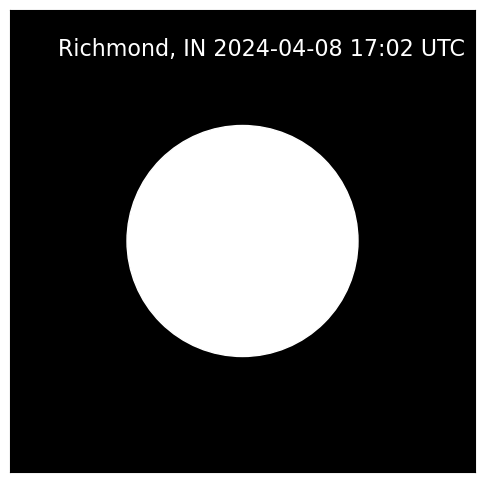

In [5]:
i0 = separation.argmin() - 128
i1 = separation.argmin() + 128


fig, ax = plt.subplots(1, 1, figsize=(6, 6))


x = np.arange(0, 2*np.pi, 0.01)

moon_pa = matplotlib.patches.Circle((0,0), radius = 1,
                              color='#000000', zorder=2)
sun_pa = matplotlib.patches.Circle((0,0), radius = 1,
                             color='#FFFFFF', zorder=1)

ax.set_aspect("equal", adjustable="datalim")

ax.add_patch(moon_pa)
ax.add_patch(sun_pa)

def animate(i):
    moon_pa.center = [moon_coords.az[i].degree, moon_coords.alt[i].degree]
    sun_pa.center = [sun_coords.az[i].degree, sun_coords.alt[i].degree]
    
    moon_pa.center = np.array(moon_pa.center) - np.array(sun_pa.center)
    

    moon_pa.height = 0.5
    sun_pa.height = 0.5
    moon_pa.width = 0.5
    sun_pa.width = 0.5
    
    sun_pa.center = [0,0]
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_facecolor((0.0, 0.0, 0.0))
    ax.set_xticks([])
    ax.set_yticks([])
    
    dstr = str(timesDT[i])[:10]
    tstr = str(timesDT[i])[11:]
    ttl = sites.long_name[siteIdx] + ' ' + dstr + ' ' + tstr + ' UTC'
 
    
    ax.text(-0.4, 0.4, ttl,color='white',fontsize=16,backgroundcolor='black',zorder=3)
    
    return moon_pa, sun_pa

def init():
    return animate(i0)

ani = animation.FuncAnimation(fig, animate, np.arange(i0, i1),
                              init_func=init, interval=50, blit=True, repeat=False)

In [6]:
HTML(ani.to_html5_video())

IndexError: index 240 is out of bounds for axis 0 with size 240